# MASINSKO UCENJE PROJEKAT 3

### Predmet projekta je klasifikacija za video igricu Counter Strike: Global Offensive. Dataset je sacinjen od parametara koji predstavljaju podatke o trenutnom stanju svakog od timova, rezultat klasifikacije je pobeda CT tima (Counter-Terrorist) ili T tima (Terrorist).

## 1. Importovanje potrebnih biblioteka

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau

2022-03-15 22:51:26.882963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 22:51:26.882985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 2. Ucitavanje podataka

In [2]:
dataset = pd.read_csv("csgo_round_snapshots.csv")
dataset.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


#### Kao sto se moze primetiti dataset se sastoji od 97 featura. Znacajniji su preostalo vreme do kraja runde u sekundama (time_left), trenutni skor u rundama (ct_score, t_score), na kojoj mapi se trenutno igra (map), da li je u zadatom trenutku postavljena C4 bomba (bomb_planted), ukupna vrednost zivota za ceo tim (ct_health, t_health, maksimum je 500=5x100), ukupna vrednost pancira za svaki tim, ukupna vrednost novca, nadalje su zadati parametri koji predstavljaju broj oruzja koje svaki tim poseduje (ct_weapon_"ime_oruzja", t_weapon_"ime_oruzja"), zadati su takodje broj bombi koje tim poseduje. I na kraju je dato koji je tim osvojio rundu.

#### Dalje se vrsi ciscenje dataseta od praznih vrednosti

In [3]:
dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)

#### Da bi se izbegi stringovi kao vrednost za map, potrebno je napraviti nove binarne kolone koje ukazuju na to koja je mapa u pitanju 

In [4]:
dataset = pd.get_dummies(dataset,prefix=['map'], columns =['map'])
dataset.head()

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,t_grenade_decoygrenade,round_winner,map_de_cache,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
0,175.00,0.0,0.0,False,500.0,500.0,0.0,0.0,4000.0,4000.0,...,0.0,CT,0,1,0,0,0,0,0,0
1,156.03,0.0,0.0,False,500.0,500.0,400.0,300.0,600.0,650.0,...,0.0,CT,0,1,0,0,0,0,0,0
2,96.03,0.0,0.0,False,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,CT,0,1,0,0,0,0,0,0
3,76.03,0.0,0.0,False,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,CT,0,1,0,0,0,0,0,0
4,174.97,1.0,0.0,False,500.0,500.0,192.0,0.0,18350.0,10750.0,...,0.0,CT,0,1,0,0,0,0,0,0


#### Potrebno je prevesti parametar bomb_planted u integer

In [5]:
dataset["bomb_planted"] = dataset["bomb_planted"].astype(int)
dataset.head()

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,t_grenade_decoygrenade,round_winner,map_de_cache,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
0,175.00,0.0,0.0,0,500.0,500.0,0.0,0.0,4000.0,4000.0,...,0.0,CT,0,1,0,0,0,0,0,0
1,156.03,0.0,0.0,0,500.0,500.0,400.0,300.0,600.0,650.0,...,0.0,CT,0,1,0,0,0,0,0,0
2,96.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,CT,0,1,0,0,0,0,0,0
3,76.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,CT,0,1,0,0,0,0,0,0
4,174.97,1.0,0.0,0,500.0,500.0,192.0,0.0,18350.0,10750.0,...,0.0,CT,0,1,0,0,0,0,0,0


#### Potrebno je uvesti labele za vrednosti round_winner, da ne bi vise bio string

In [6]:
dataset["round_winner"] = [int(dataset["round_winner"][i]=="CT") for i in range(dataset.shape[0])]

In [7]:
dataset["round_winner"]

0         1
1         1
2         1
3         1
4         1
         ..
122405    0
122406    0
122407    0
122408    0
122409    0
Name: round_winner, Length: 122410, dtype: int64

In [8]:
X = dataset.drop('round_winner', axis=1)
y = dataset['round_winner']
print(X.shape)
print(y.shape)

(122410, 103)
(122410,)


## 3. Obucavanje modela bez normalizacije dataseta

#### Model se sastoji 5 slojeva sa po 64, 32, 16, 8 cvorova i zadnji sloj koji predstavlja predikciju

In [9]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape = (103,) ))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
history=model.fit(X, y, epochs=10, batch_size=32, validation_split = .2)

Train on 97928 samples, validate on 24482 samples
Epoch 1/10
   32/97928 [..............................] - ETA: 4:33 - loss: 648.8333 - accuracy: 0.4688

2022-03-15 22:51:29.168230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 22:51:29.168496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 22:51:29.168549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-15 22:51:29.168575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-15 22:51:29.168600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

96896/97928 [============================>.] - ETA: 0s - loss: 2.1012 - accuracy: 0.5309

/home/medox/Masinski/Masinsko-ucenje/mas/lib/python3.10/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


97928/97928 [==============================] - 5s 50us/sample - loss: 2.0864 - accuracy: 0.5307 - val_loss: 0.6883 - val_accuracy: 0.5027
Epoch 2/10
97928/97928 [==============================] - 5s 51us/sample - loss: 0.6919 - accuracy: 0.5112 - val_loss: 0.6933 - val_accuracy: 0.5027
Epoch 3/10
97928/97928 [==============================] - 5s 51us/sample - loss: 0.6929 - accuracy: 0.5116 - val_loss: 0.6935 - val_accuracy: 0.5027
Epoch 4/10
97928/97928 [==============================] - 5s 50us/sample - loss: 0.6936 - accuracy: 0.5116 - val_loss: 0.6933 - val_accuracy: 0.5027
Epoch 5/10
97928/97928 [==============================] - 5s 50us/sample - loss: 0.6929 - accuracy: 0.5116 - val_loss: 0.6933 - val_accuracy: 0.5027
Epoch 6/10
97928/97928 [==============================] - 5s 50us/sample - loss: 0.6929 - accuracy: 0.5116 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 7/10
97928/97928 [==============================] - 5s 54us/sample - loss: 0.6929 - accuracy: 0.5116 - val_loss

#### Grafik Test tacnosti za prethodni model

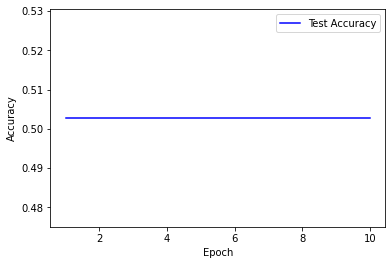

In [11]:
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(test_acc) + 1)
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [12]:
model1 = Sequential()
model1.add(Dense(128, activation='relu', input_shape = (103,) ))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history=model1.fit(X, y, epochs=10, batch_size=32, validation_split = .2)

Train on 97928 samples, validate on 24482 samples
Epoch 1/10
97928/97928 [==============================] - 5s 55us/sample - loss: 4.8730 - accuracy: 0.6590 - val_loss: 0.9591 - val_accuracy: 0.6609
Epoch 2/10
97928/97928 [==============================] - 5s 52us/sample - loss: 0.6314 - accuracy: 0.6998 - val_loss: 0.7122 - val_accuracy: 0.6388
Epoch 3/10
97928/97928 [==============================] - 5s 56us/sample - loss: 0.6047 - accuracy: 0.6884 - val_loss: 0.5451 - val_accuracy: 0.7045
Epoch 4/10
97928/97928 [==============================] - 6s 58us/sample - loss: 0.5312 - accuracy: 0.7180 - val_loss: 0.5245 - val_accuracy: 0.7299
Epoch 5/10
97928/97928 [==============================] - 6s 59us/sample - loss: 0.5170 - accuracy: 0.7229 - val_loss: 0.5040 - val_accuracy: 0.7151
Epoch 6/10
97928/97928 [==============================] - 5s 55us/sample - loss: 0.5034 - accuracy: 0.7287 - val_loss: 0.5010 - val_accuracy: 0.7339
Epoch 7/10
97928/97928 [==============================] 

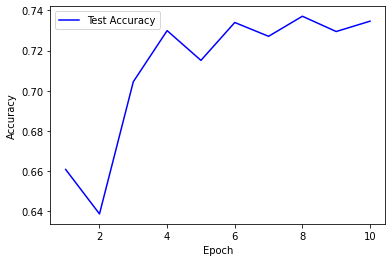

In [14]:
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(test_acc) + 1)
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Treniranje modela sa promenjenim learning ratom

In [15]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model1_opt = Sequential()
model1_opt.add(Dense(128, activation='relu', input_shape = (103,) ))
model1_opt.add(Dense(64, activation='relu'))
model1_opt.add(Dense(32, activation='relu'))
model1_opt.add(Dense(16, activation='relu'))
model1_opt.add(Dense(1, activation='sigmoid'))

model1_opt.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history=model1_opt.fit(X, y, epochs=10, batch_size=32, validation_split = .2)

Train on 97928 samples, validate on 24482 samples
Epoch 1/10
97928/97928 [==============================] - 6s 63us/sample - loss: 1.5706 - accuracy: 0.6731 - val_loss: 0.5270 - val_accuracy: 0.7263
Epoch 2/10
97928/97928 [==============================] - 6s 58us/sample - loss: 0.5589 - accuracy: 0.7142 - val_loss: 0.5343 - val_accuracy: 0.7279
Epoch 3/10
97928/97928 [==============================] - 5s 55us/sample - loss: 0.5440 - accuracy: 0.7247 - val_loss: 0.4978 - val_accuracy: 0.7260
Epoch 4/10
97928/97928 [==============================] - 5s 55us/sample - loss: 0.5322 - accuracy: 0.7225 - val_loss: 0.5250 - val_accuracy: 0.7274
Epoch 5/10
97928/97928 [==============================] - 6s 57us/sample - loss: 0.5165 - accuracy: 0.7279 - val_loss: 0.5143 - val_accuracy: 0.7193
Epoch 6/10
97928/97928 [==============================] - 6s 57us/sample - loss: 0.5006 - accuracy: 0.7333 - val_loss: 0.4963 - val_accuracy: 0.7211
Epoch 7/10
97928/97928 [==============================] 

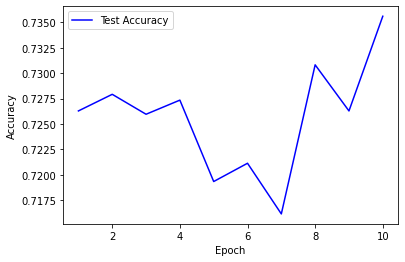

In [17]:
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(test_acc) + 1)
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model1_opt1 = Sequential()
model1_opt1.add(Dense(128, activation='relu', input_shape = (103,) ))
model1_opt1.add(Dense(64, activation='relu'))
model1_opt1.add(Dense(32, activation='relu'))
model1_opt1.add(Dense(16, activation='relu'))
model1_opt1.add(Dense(1, activation='sigmoid'))

model1_opt1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
history=model1_opt1.fit(X, y, epochs=10, batch_size=32, validation_split = .2)

Train on 97928 samples, validate on 24482 samples
Epoch 1/10
97928/97928 [==============================] - 6s 57us/sample - loss: 3.1158 - accuracy: 0.6632 - val_loss: 0.6798 - val_accuracy: 0.6947
Epoch 2/10
97928/97928 [==============================] - 6s 60us/sample - loss: 0.6027 - accuracy: 0.7108 - val_loss: 0.5252 - val_accuracy: 0.7216
Epoch 3/10
97928/97928 [==============================] - 6s 63us/sample - loss: 0.5361 - accuracy: 0.7229 - val_loss: 0.5672 - val_accuracy: 0.6789
Epoch 4/10
97928/97928 [==============================] - 6s 61us/sample - loss: 0.5256 - accuracy: 0.7232 - val_loss: 0.5417 - val_accuracy: 0.7020
Epoch 5/10
97928/97928 [==============================] - 6s 59us/sample - loss: 0.5131 - accuracy: 0.7275 - val_loss: 0.5299 - val_accuracy: 0.7259
Epoch 6/10
97928/97928 [==============================] - 6s 59us/sample - loss: 0.5054 - accuracy: 0.7312 - val_loss: 0.4978 - val_accuracy: 0.7216
Epoch 7/10
97928/97928 [==============================] 

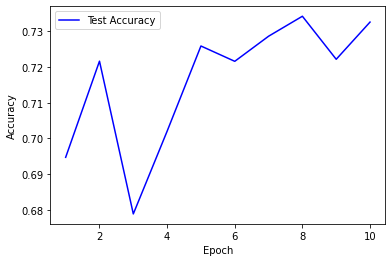

In [20]:
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(test_acc) + 1)
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 4. Treniranje nad normalizovanim podacima

In [21]:
eps = 0.000001
X_normalized=(X-X.min())/(X.max()-X.min()+eps) - 0.5

In [22]:
X_normalized.head()

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,ct_grenade_decoygrenade,t_grenade_decoygrenade,map_de_cache,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
0,0.500000,-0.50000,-0.5,-0.5,0.500,0.333333,-0.500,-0.5,-0.450000,-0.450000,...,-0.5,-0.5,-0.5,0.499999,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
1,0.391594,-0.50000,-0.5,-0.5,0.500,0.333333,0.300,0.1,-0.492500,-0.491875,...,-0.5,-0.5,-0.5,0.499999,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
2,0.048717,-0.50000,-0.5,-0.5,0.282,0.166667,0.088,-0.1,-0.490625,-0.493750,...,-0.5,-0.5,-0.5,0.499999,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
3,-0.065575,-0.50000,-0.5,-0.5,0.282,0.166667,0.088,-0.1,-0.490625,-0.493750,...,-0.5,-0.5,-0.5,0.499999,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
4,0.499829,-0.46875,-0.5,-0.5,0.500,0.333333,-0.116,-0.5,-0.270625,-0.365625,...,-0.5,-0.5,-0.5,0.499999,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5


In [23]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape = (103,) ))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(X_normalized, y, epochs=10, batch_size=32, validation_split = .2)

Train on 97928 samples, validate on 24482 samples
Epoch 1/10
97312/97928 [============================>.] - ETA: 0s - loss: 0.4809 - accuracy: 0.7421

/home/medox/Masinski/Masinsko-ucenje/mas/lib/python3.10/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


97928/97928 [==============================] - 6s 56us/sample - loss: 0.4805 - accuracy: 0.7423 - val_loss: 0.4751 - val_accuracy: 0.7409
Epoch 2/10
97928/97928 [==============================] - 6s 60us/sample - loss: 0.4613 - accuracy: 0.7500 - val_loss: 0.4671 - val_accuracy: 0.7455
Epoch 3/10
97928/97928 [==============================] - 5s 56us/sample - loss: 0.4557 - accuracy: 0.7522 - val_loss: 0.4609 - val_accuracy: 0.7433
Epoch 4/10
97928/97928 [==============================] - 6s 57us/sample - loss: 0.4516 - accuracy: 0.7533 - val_loss: 0.4621 - val_accuracy: 0.7418
Epoch 5/10
97928/97928 [==============================] - 6s 59us/sample - loss: 0.4484 - accuracy: 0.7552 - val_loss: 0.4583 - val_accuracy: 0.7432
Epoch 6/10
97928/97928 [==============================] - 5s 56us/sample - loss: 0.4463 - accuracy: 0.7568 - val_loss: 0.4573 - val_accuracy: 0.7421
Epoch 7/10
97928/97928 [==============================] - 6s 57us/sample - loss: 0.4441 - accuracy: 0.7569 - val_loss

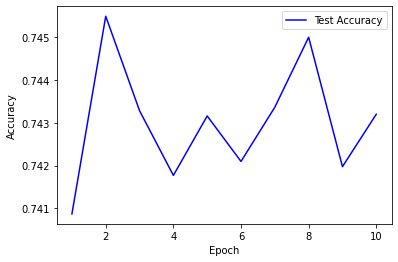

In [25]:
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(test_acc) + 1)
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [26]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model = Sequential()
model.add(Dense(256, activation='relu', input_shape = (103,) ))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(X_normalized, y, epochs=10, batch_size=32, validation_split = .2)

Train on 97928 samples, validate on 24482 samples
Epoch 1/10
97928/97928 [==============================] - 7s 69us/sample - loss: 0.4816 - accuracy: 0.7437 - val_loss: 0.4736 - val_accuracy: 0.7425
Epoch 2/10
97928/97928 [==============================] - 7s 70us/sample - loss: 0.4648 - accuracy: 0.7489 - val_loss: 0.4648 - val_accuracy: 0.7415
Epoch 3/10
97928/97928 [==============================] - 6s 65us/sample - loss: 0.4591 - accuracy: 0.7510 - val_loss: 0.4632 - val_accuracy: 0.7410
Epoch 4/10
97928/97928 [==============================] - 7s 67us/sample - loss: 0.4567 - accuracy: 0.7521 - val_loss: 0.4753 - val_accuracy: 0.7349
Epoch 5/10
97928/97928 [==============================] - 7s 67us/sample - loss: 0.4531 - accuracy: 0.7537 - val_loss: 0.4627 - val_accuracy: 0.7451
Epoch 6/10
97928/97928 [==============================] - 7s 69us/sample - loss: 0.4519 - accuracy: 0.7540 - val_loss: 0.4594 - val_accuracy: 0.7425
Epoch 7/10
97928/97928 [==============================] 

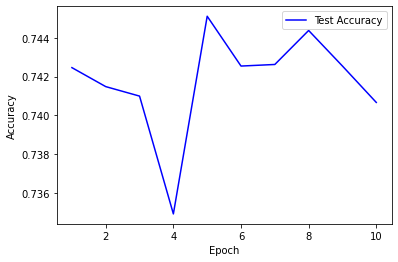

In [28]:
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(test_acc) + 1)
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [29]:
opt = keras.optimizers.Adam(learning_rate=0.00001)
model = Sequential()
model.add(Dense(64, activation='relu', input_shape = (103,) ))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(X_normalized, y, epochs=10, batch_size=32, validation_split = .2)

Train on 97928 samples, validate on 24482 samples
Epoch 1/10
97928/97928 [==============================] - 6s 60us/sample - loss: 0.6548 - accuracy: 0.6532 - val_loss: 0.5966 - val_accuracy: 0.7112
Epoch 2/10
97928/97928 [==============================] - 6s 62us/sample - loss: 0.5565 - accuracy: 0.7316 - val_loss: 0.5370 - val_accuracy: 0.7315
Epoch 3/10
97928/97928 [==============================] - 6s 66us/sample - loss: 0.5202 - accuracy: 0.7412 - val_loss: 0.5192 - val_accuracy: 0.7327
Epoch 4/10
97928/97928 [==============================] - 6s 64us/sample - loss: 0.5057 - accuracy: 0.7448 - val_loss: 0.5101 - val_accuracy: 0.7348
Epoch 5/10
97928/97928 [==============================] - 6s 59us/sample - loss: 0.4970 - accuracy: 0.7475 - val_loss: 0.5045 - val_accuracy: 0.7365
Epoch 6/10
97928/97928 [==============================] - 6s 63us/sample - loss: 0.4909 - accuracy: 0.7497 - val_loss: 0.5003 - val_accuracy: 0.7362
Epoch 7/10
97928/97928 [==============================] 

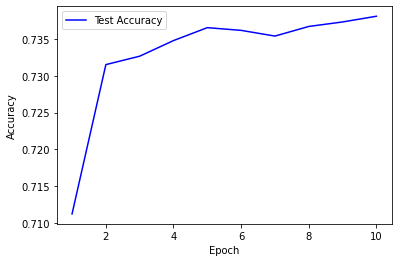

In [31]:
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(test_acc) + 1)
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### Treniranje sa dinamickim izborom learning rata

In [32]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,verbose = 1,
                              patience=5, min_lr=0.00000001)

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape = (103,) ))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(X_normalized, y, epochs=50, batch_size=32, validation_split = .2, callbacks=[reduce_lr])

Train on 97928 samples, validate on 24482 samples
Epoch 1/50
97928/97928 [==============================] - 29s 295us/sample - loss: 0.4738 - accuracy: 0.7466 - val_loss: 0.4707 - val_accuracy: 0.7410 - lr: 1.0000e-04
Epoch 2/50
97928/97928 [==============================] - 29s 299us/sample - loss: 0.4542 - accuracy: 0.7544 - val_loss: 0.4627 - val_accuracy: 0.7406 - lr: 1.0000e-04
Epoch 3/50
97928/97928 [==============================] - 28s 289us/sample - loss: 0.4468 - accuracy: 0.7574 - val_loss: 0.4676 - val_accuracy: 0.7406 - lr: 1.0000e-04
Epoch 4/50
97928/97928 [==============================] - 28s 290us/sample - loss: 0.4421 - accuracy: 0.7612 - val_loss: 0.4574 - val_accuracy: 0.7442 - lr: 1.0000e-04
Epoch 5/50
97928/97928 [==============================] - 29s 292us/sample - loss: 0.4388 - accuracy: 0.7636 - val_loss: 0.4621 - val_accuracy: 0.7364 - lr: 1.0000e-04
Epoch 6/50
97928/97928 [==============================] - 28s 288us/sample - loss: 0.4353 - accuracy: 0.7667 -

97928/97928 [==============================] - 15s 157us/sample - loss: 0.0962 - accuracy: 0.9586 - val_loss: 1.3486 - val_accuracy: 0.7147 - lr: 1.0000e-04
Epoch 50/50
97928/97928 [==============================] - 16s 160us/sample - loss: 0.0911 - accuracy: 0.9609 - val_loss: 1.5198 - val_accuracy: 0.7127 - lr: 1.0000e-04


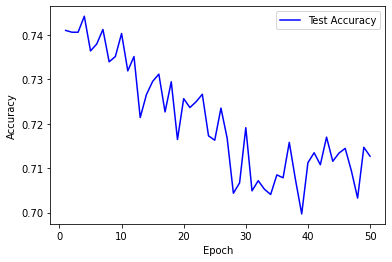

In [34]:
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(test_acc) + 1)
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [35]:
opt = keras.optimizers.Adam(learning_rate=0.000001)
model = Sequential()
model.add(Dense(64, activation='relu', input_shape = (103,) ))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='tanh'))
model.compile(optimizer=opt, loss='hinge', metrics=['accuracy'])

In [36]:
history = model.fit(X_normalized, y, epochs=10, batch_size=32, validation_split = .2, callbacks=[reduce_lr])

Train on 97928 samples, validate on 24482 samples
Epoch 1/10
97928/97928 [==============================] - 6s 63us/sample - loss: 0.9934 - accuracy: 0.5116 - val_loss: 0.9929 - val_accuracy: 0.5027 - lr: 1.0000e-06
Epoch 2/10
97928/97928 [==============================] - 6s 62us/sample - loss: 0.9870 - accuracy: 0.5116 - val_loss: 0.9863 - val_accuracy: 0.5027 - lr: 1.0000e-06
Epoch 3/10
97928/97928 [==============================] - 6s 62us/sample - loss: 0.9796 - accuracy: 0.5116 - val_loss: 0.9784 - val_accuracy: 0.5027 - lr: 1.0000e-06
Epoch 4/10
97928/97928 [==============================] - 6s 62us/sample - loss: 0.9703 - accuracy: 0.5116 - val_loss: 0.9682 - val_accuracy: 0.5027 - lr: 1.0000e-06
Epoch 5/10
97928/97928 [==============================] - 6s 63us/sample - loss: 0.9572 - accuracy: 0.5116 - val_loss: 0.9542 - val_accuracy: 0.5027 - lr: 1.0000e-06
Epoch 6/10
97928/97928 [==============================] - 6s 62us/sample - loss: 0.9414 - accuracy: 0.5116 - val_loss: 0

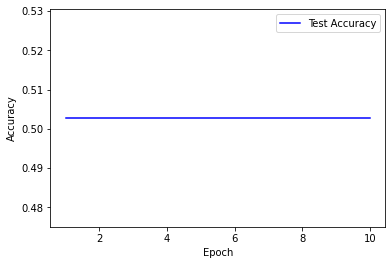

In [37]:
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(test_acc) + 1)
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()